# Introduction

In [1]:
# This is the complete commented source code for reproducing all numerical examinations
# presented in the manuscript "On minimising tumoural growth under treatment resistance"
# by Fischer and Bluethgen.

# Note that two data files are required, which contain the data from the experiments
# by Hong et al (2018), which we have extracted using the WebPlotDigitizer software.
# The files are present in this supplement and called "S-MEKi-with-SD.csv" and
# "R-MEKi-withdrawal-with-SD.csv", respectively.
# The first file contains the data from Hong et al.'s Figure 5a, where sensitive xenografts
# have been left untreated for some time, after which treatment was switched on.
# The second file contains the data from Hong et al.'s Figure 5b, where initially resistant
# xenografts have been treated right from implantation for some time, after which
# treatment was switched off.

# Loading required software libraries

In [2]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Data handling, numerics
import pandas as pd
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

# System definitions

In [3]:
def PT(ts, t_switch, N0, betaSstar, betaRstar, alpha, betaS):
    """
    Return the size of a tumour at timepoints ts that begins treatment-naive
    and is first not treated for t_switch units of time, after which treatment
    is switched on for the remaining amount of time.
    This will be fitted to the data from Hong et al.'s Figure 5a.
    """
    
    # As the tumour is treatment-naive, we assume it initially consists
    # of only sensitive cells.
    y0 = [N0, 0]
    
    # Coefficient matrix for the first phase, where no treatment is applied.
    # Because we assume that no resistant cells are present for now, there is
    # no flow from the resistant compartment to the sensitive one in this phase,
    # as well as no growth in the resistant compartment.
    # Hence, we set P_{1,2} = P_{2,2} = 0 by setting betaR = delta = 0.
    betaR = 0
    delta = 0
    P = np.array([[betaS, delta],
                  [0,     betaR-delta]])
    
    # Coefficient matrix for the second phase, where treatment is applied.
    T = np.array([[betaSstar-alpha, 0],
                  [alpha,           betaRstar]])
    
    # Calculate and return tumour sizes at all timepoints stored in ts
    Ns = []
    for t in ts:
        if t < t_switch:
            Ns.append(np.sum(sp.linalg.expm(t*P).dot(y0)))
        else:
            Ns.append(np.sum(sp.linalg.expm((t-t_switch)*T).dot(sp.linalg.expm(t_switch*P).dot(y0))))   
    return Ns
            

In [4]:
def TP(ts, t_switch, N0, betaRstar, betaS, betaR, delta):
    """
    Return the size of a tumour at timepoints ts that begins entirely resistant
    and is first treated for t_switch units of time, after which treatment is
    switched off for the remaining amount of time.
    This will be fitted to the data from Hong et al.'s Figure 5b.
    """
    
    # As the tumour starts entirely resistant, we assume initially all of its cells
    # are treatment-resistant.
    y0 = [0, N0]
    
    # Coefficient matrix for the first phase, where treatment is applied.
    # Because we assume that no sensitive cells are present for now, there is
    # no flow from the sensitive compartment to the resistant one in this phase,
    # as well as no growth in the sensitive compartment.
    # Hence, we set T_{1,1} = T_{2,1} = 0 by setting alpha = betaSstar = 0.
    alpha = 0
    betaSstar = 0
    T = np.array([[betaSstar-alpha, 0],
                  [alpha,           betaRstar]])
    
    # Coefficient matrix for the second phase, where treatment is not applied anymore.
    P = np.array([[betaS, delta],
                  [0,     betaR-delta]])
    
    # Calculate and return tumour sizes at all timepoints stored in ts
    Ns = []
    for t in ts:
        if t < t_switch:
            Ns.append(np.sum(sp.linalg.expm(t*T).dot(y0)))
        else:
            Ns.append(np.sum(sp.linalg.expm((t-t_switch)*P).dot(sp.linalg.expm(t_switch*T).dot(y0))))  
    return Ns

# Fitting data from Figure 5a of Hong et al. (2018)
# This produces the left panel of Figure 3a of our manuscript

beta_S 0.18031238843450373 +/- 0.07341441066951024
beta_S^* -0.2268840426319555 +/- 0.10525505716342044
beta_R^* 0.12713228878716362 +/- 0.06453369150777684
alpha 0.02468295583568541 +/- 0.03247614753501138


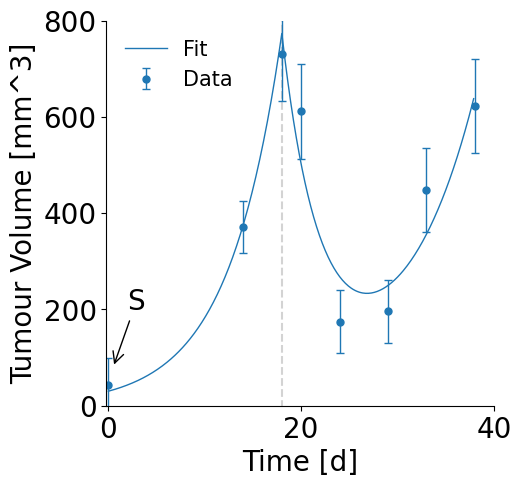

In [5]:
# Load data. Time does not start at zero, so we need to shift all time points, 
# as well as the time of treatment start (t_switch) by an offset.
dat = pd.read_csv("S-MEKi-with-SD.csv")
offset = list(dat.t)[0]
dat.t -= offset
t_switch = 25 - offset

# We remove data points after 40 days, as growth seems to leave the exponential
# regimen there.
dat = dat[dat.t < 40]

# Convenience: Store time, tumour volume and tumour volume SD in individual arrays.
t  = dat.t
V  = dat.V
SD = dat.SDUpper - dat.V

# Convenience: The function we want to fit, with t_switch properly pre-set
f = lambda ts, N0, betaSstar, betaRstar, alpha, betaS : PT(ts=ts,
                                                           t_switch=t_switch,
                                                           N0=N0,
                                                           betaSstar=betaSstar,
                                                           betaRstar=betaRstar,
                                                           alpha=alpha,
                                                           betaS=betaS)

# Initial estimate for solver
guess = [50, -0.1, 0.1, 0.1, 0.1]

# The actual fit
popt, pcov = curve_fit(f = f, xdata = t, ydata = V, p0 = guess)

# Extracting parameter standard deviations from covariance matrix
SDs = np.sqrt(np.diag(pcov))

# Print results: mean estimates and SDs
print (f"beta_S {popt[4]} +/- {SDs[4]}")
print (f"beta_S^* {popt[1]} +/- {SDs[1]}")
print (f"beta_R^* {popt[2]} +/- {SDs[2]}")
print (f"alpha {popt[3]} +/- {SDs[3]}")

# Plot raw data
fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.errorbar(x=t, y=V, yerr=SD, label="Data",
            markersize=5, marker="o", linestyle="", 
            ecolor="C0", elinewidth=1, capsize=3)

# Plot fit
xs = np.arange(0,max(t),0.1)
ax.plot(xs, f(xs, *popt), c="C0", ls="-", lw=1, label="Fit")

# Annotate onset of treatment
ax.vlines([t_switch], -50, 1000, ls="--", color="lightgrey", zorder=-100)

# Annotate initial tumour state as sensitive (S)
ax.annotate(text="S", xy=(.5,80), xytext=(2,200),
            fontsize=20,
            arrowprops={"arrowstyle": "->", "ls":"-"})

# General aesthetics
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((-0.2,40))
ax.set_ylim((0,800))
ax.tick_params("both", labelsize=20)
ax.set_xlabel("Time [d]", size=20)
ax.set_ylabel("Tumour Volume [mm^3]", size=20)
ax.legend(loc=2, frameon=False, fontsize=15)

# Fitting data from Figure 5b of Hong et al. (2018)
# This produces the right panel of Figure 3a of our manuscript

beta_S 0.20674416129333098 +/- 0.118169927635705
beta_R -0.22816394173305024 +/- 0.07885437149784447
beta_R^* 0.06972606507167921 +/- 0.003993654819230556
delta 0.13055207595092255 +/- 0.14725791131336347


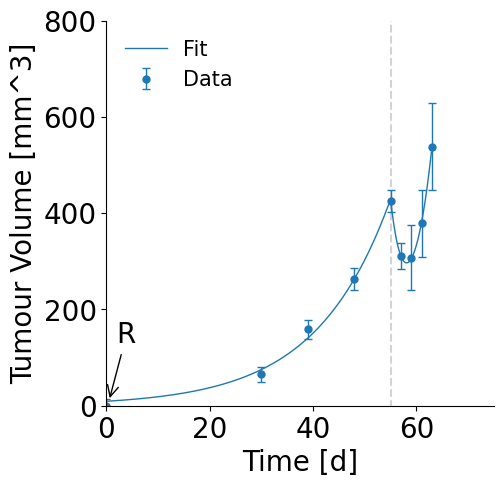

In [6]:
# Load data
dat = pd.read_csv("R-MEKi-withdrawal-with-SD.csv")

# Convenience: Store time, tumour volume and tumour volume SD in individual arrays.
t = dat.t
V = dat.V
SD = dat.SDUpper - dat.V

# Convenience: The function we want to fit, with t_switch properly pre-set
t_switch = 55
f = lambda ts, N0, betaRstar, betaS, betaR, delta : TP(ts=ts,
                                                       t_switch=t_switch,
                                                       N0=N0,
                                                       betaRstar=betaRstar,
                                                       betaS=betaS,
                                                       betaR=betaR,
                                                       delta=delta)

# Initial estimate for solver
guess = [50, 0.1, 0.1, -0.1, 0.1]

# The actual fit
popt, pcov = curve_fit(f = f, xdata = t, ydata = V, sigma=SD, p0 = guess)

# Extracting parameter standard deviations from covariance matrix
SDs = np.sqrt(np.diag(pcov))

# Print results: mean estimates and SDs
print (f"beta_S {popt[2]} +/- {SDs[2]}")
print (f"beta_R {popt[3]} +/- {SDs[3]}")
print (f"beta_R^* {popt[1]} +/- {SDs[1]}")
print (f"delta {popt[4]} +/- {SDs[4]}")

# Plot raw data
fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.errorbar(x=t, y=V, yerr=SD, label="Data",
            markersize=5, marker="o", linestyle="", 
            ecolor="C0", elinewidth=1, capsize=3)

# Plot fit
xs = np.arange(0,max(t),0.1)
ax.plot(xs, f(xs, *popt), c="C0", ls="-", lw=1, label="Fit")

# Annotate termination of treatment
ax.vlines([55], -50, 1000, ls="--", color="lightgrey", zorder=-100)

# Annotate initial tumour state as resistant (R)
ax.annotate(text="R", xy=(.5,10), xytext=(2,130),
            fontsize=20,
            arrowprops={"arrowstyle": "->", "ls":"-"})

# General aesthetics
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0,75))
ax.set_ylim((0,800))
ax.tick_params("both", labelsize=20)
ax.set_xlabel("Time [d]", size=20)
ax.set_ylabel("Tumour Volume [mm^3]", size=20)
ax.legend(loc=2, frameon=False, fontsize=15)

# Figure 3b of our manuscript

In [7]:
# The system after change of variables from (S,R) to (N,Q) (see Section 3.2)

def dYdt_T(t, Y):
    """ Return gradient of the system during treatment phase. """
    
    # Parameters from fit
    betaSstar = -0.22
    betaRstar = 0.10
    alpha = .02
    
    # See Section 3.2
    N, Q = Y
    dNdt = (betaSstar * (1-Q) + betaRstar * Q) * N
    dQdt = (betaSstar - betaRstar)*Q**2 + (betaRstar - betaSstar - alpha)*Q + alpha
    return [dNdt, dQdt]

def dYdt_P(t, Y):
    """ Return gradient of the system during pause phase. """
    
    # Parameters from fit
    betaS = 0.19
    betaR = -0.22
    delta = 0.10

    # See Section 3.2
    N, Q = Y
    dNdt = (betaS * (1-Q) + betaR * Q) * N
    dQdt = (betaS - betaR)*Q**2 + (betaR - betaS - delta)*Q
    return [dNdt, dQdt]

In [8]:
def t1t2n(Qa,Qb):
    """
    Given two interval borders (Qa, Qb), calculate numerically
     - the duration t1 of treatment required for Q to increase from Qa to Qb
     - the duration t2 of pause required for Q to decrease back from Qb to Qa
     - the final population size n of the tumour when initial popul. size was set to 1.0
    """
    
    # Event function for Q reaching Qa, makes the solver stop
    def reached_Qa(t, Y):
        _, Q = Y
        return Qa-Q
    reached_Qa.terminal = True
    
    # Event function for Q reaching Qb, makes the solver stop 
    def reached_Qb(t, Y):
        _, Q = Y
        return Qb-Q
    reached_Qb.terminal = True

    # The actual numerical simulation of the treatment phase ...
    sol1 = solve_ivp(dYdt_T, t_span=(0,50), y0=[1,Qa], max_step = 0.01, events=reached_Qb)
    
    # ... and the pause phase
    sol2 = solve_ivp(dYdt_P, t_span=(0,50), y0=[sol1.y[0][-1],Qb], max_step = 0.01, events=reached_Qa)
    
    # Return t1, t2, n
    return sol1.t[-1], sol2.t[-1], sol2.y[0][-1]

In [9]:
# Now, systematically simulate different protocols, defined by pairs (Qa, Qb),
# which define the switching points in Q(t) where we start and stop treatment,
# respectively. 

# Select how many points between 0.01 and 0.99 we want to evaluate for Qa and Qb
# The higher the number of points we evaluate, the higher the plot's resolution will be.
# However, we will also require more time for the calculations.
# With 100 points, this runs in ~3min on my (rather beefy) machine 
points = 100
qas = np.linspace(0.01, 0.99, points)
qbs = np.linspace(0.01, 0.99, points)

# Results shown in the heatmap are stored in here,
# containing the actual growth rate of the respective simulated protocol
hm = np.zeros((len(qas), len(qbs)))

# The actual simulation
for i,qa in enumerate(qas):
    for j,qb in enumerate(qbs):
        # Initialise result with NaN just in case
        hm[i,j] = float("nan")
        
        # Qa needs to be smaller than Qb by definition
        if qa < qb:
            # Simulate current scenario
            t_T, t_P, n = t1t2n(qa,qb)
            
            # Sanity check to avoid division by zero
            # Will always evaluate to True except for cases of
            # floating point imprecisions
            if t_T + t_P > 0:
                # Calculate growth rate of this simulated protocol
                hm[i,j] = np.log(n) / (t_T+t_P)
                
                # Print it on screen so users knows we're still working
                print (qa,qb, t_T, t_P, n, hm[i,j])

# Make a meshgrid out of the evaluated values for easier plotting later
qas, qbs = np.meshgrid(qas, qbs, indexing="ij") 

0.01 0.0198989898989899 0.40598800504746146 1.3649779180467885 1.178100185657947 0.09255013138510441
0.01 0.029797979797979796 0.7695185797921696 2.1726090850546758 1.261292217542078 0.07890098301231237
0.01 0.039696969696969696 1.0993279901910327 2.7510816380784897 1.3033801062243013 0.06881371007087826
0.01 0.049595959595959596 1.4017249058099577 3.2038048515453 1.3238054306766174 0.060907323546323854
0.01 0.059494949494949496 1.6814147318058617 3.5769520674734454 1.331665028880949 0.05447129719288413
0.01 0.06939393939393938 1.9420012925749497 3.8951892976257185 1.3318146992847788 0.04908910260200005
0.01 0.07929292929292929 2.1863064711996962 4.17325467293437 1.3270677809461593 0.04449549677469798
0.01 0.08919191919191918 2.416581739701093 4.4206618268398525 1.3191488066121129 0.04051145500755667
0.01 0.09909090909090908 2.634652693004029 4.643910686766272 1.309159243016295 0.03701075581704619
0.01 0.10898989898989898 2.8420205411857102 4.847639972543356 1.2978247231056126 0.033901

0.01 0.8316161616161616 12.599141050247596 10.817657022770428 0.7458734101513437 -0.012520899900553805
0.01 0.8415151515151514 12.809722077802492 10.888511842769283 0.745282293456548 -0.012405659255776722
0.01 0.8514141414141414 13.031447199015403 10.960282330730028 0.7452898140752368 -0.01225347775374793
0.01 0.8613131313131313 13.265910426443035 11.033035409731955 0.745999379646419 -0.012059391889982255
0.01 0.8712121212121212 13.5150583827488 11.106842558237208 0.747541844474485 -0.011817324614837067
0.01 0.8811111111111111 13.781303393667038 11.181780333609584 0.7500853462487367 -0.011519741994592013
0.01 0.891010101010101 14.067685858082033 11.257930966182059 0.7538498196598711 -0.011157165921897735
0.01 0.9009090909090909 14.378114144916497 11.335383036049537 0.7591290694401677 -0.010717463367229911
0.01 0.9108080808080807 14.71773117554997 11.414232247250808 0.7663255586646515 -0.010184775782653
0.01 0.9207070707070707 15.093497559931764 11.494582317092062 0.7760076222282026 -0.

0.0198989898989899 0.6039393939393939 8.813130641354206 7.963287702925952 0.7085673630362206 -0.02053538120685288
0.0198989898989899 0.6138383838383838 8.930941181191036 8.025732343653177 0.7038444712655724 -0.020711483783305108
0.0198989898989899 0.6237373737373737 9.050054940022731 8.088151052549875 0.6992179201587465 -0.02087691241467425
0.0198989898989899 0.6336363636363637 9.17059306858256 8.150575468852445 0.6946890306984778 -0.02103154706936353
0.0198989898989899 0.6435353535353535 9.292684426722781 8.213037249164877 0.6902595329388987 -0.021175226264923484
0.0198989898989899 0.6534343434343434 9.416466580811596 8.275568163907533 0.6859316084437723 -0.02130774429350874
0.0198989898989899 0.6633333333333333 9.542086936597713 8.338200194634242 0.6817079402952898 -0.021428847874964668
0.0198989898989899 0.6732323232323232 9.669704032571035 8.40096563296581 0.6775917721180169 -0.02153823215214125
0.0198989898989899 0.6831313131313131 9.799489024166858 8.46389718191208 0.673586977897

0.029797979797979796 0.3564646464646465 5.6567401163107185 5.4808197151802975 0.8031947098964637 -0.019677390709137578
0.029797979797979796 0.36636363636363634 5.771017169490599 5.556522789084949 0.7961907046421889 -0.02012056845258664
0.029797979797979796 0.37626262626262624 5.88444474104586 5.631043375684714 0.7893235786201164 -0.020544411794935182
0.029797979797979796 0.38616161616161615 5.997115746821553 5.704461584638965 0.7825891245244708 -0.0209499505027111
0.029797979797979796 0.39606060606060606 6.109119643228441 5.776852075877669 0.775983310295462 -0.021338117940641325
0.029797979797979796 0.40595959595959596 6.2205428926388056 5.84828462691975 0.7695022851934333 -0.021709760585354045
0.029797979797979796 0.41585858585858587 6.331469394084816 5.918824633520965 0.7631423836395761 -0.022065646279460588
0.029797979797979796 0.4257575757575757 6.441980884928052 5.988533553183477 0.7569001274466255 -0.02240647140341547
0.029797979797979796 0.43565656565656563 6.552157318539696 6.0

0.039696969696969696 0.15848484848484848 2.656579370717901 2.9181163524666975 0.9465350588379796 -0.009856550248155243
0.039696969696969696 0.16838383838383839 2.820266453968132 3.0548790085143227 0.936527811993601 -0.011161606151465598
0.039696969696969696 0.1782828282828283 2.9789588290133695 3.185019453537218 0.9266240438292778 -0.01236333977795237
0.039696969696969696 0.18818181818181817 3.133102770176963 3.3092748234541323 0.9168546186598362 -0.01347427377665214
0.039696969696969696 0.19808080808080808 3.2830942260993083 3.428269364804107 0.9072406398128713 -0.014504883951167363
0.039696969696969696 0.207979797979798 3.429286402990799 3.542536495744699 0.8977960717429119 -0.015464008428701546
0.039696969696969696 0.21787878787878787 3.5719959886785477 3.6525357336320643 0.8885296353761971 -0.016359160994189527
0.039696969696969696 0.22777777777777777 3.7115083009331857 3.758665859362406 0.879446191767469 -0.017196774051043646
0.039696969696969696 0.23767676767676768 3.848081576996

0.039696969696969696 0.8613131313131313 12.166582436251979 8.281953771653466 0.5723575003821963 -0.027287600270870165
0.039696969696969696 0.8712121212121212 12.415730392557746 8.355760920158717 0.5735409347623123 -0.02676389285190637
0.039696969696969696 0.8811111111111111 12.681975403475995 8.430698695531095 0.575492400617979 -0.02617050086362405
0.039696969696969696 0.891010101010101 12.968357867890981 8.506849328103566 0.5783806397380605 -0.02549559013794733
0.039696969696969696 0.9009090909090909 13.278786154725454 8.584301397971045 0.5824310696587599 -0.024724066744523526
0.039696969696969696 0.9108080808080807 13.618403185358915 8.663150609172316 0.5879524744969338 -0.02383627124630436
0.039696969696969696 0.9207070707070707 13.994169569740713 8.743500679013575 0.5953809011832936 -0.022805938450550036
0.039696969696969696 0.9306060606060605 14.41583763566687 8.825464364144624 0.6053556903884263 -0.021596856996826
0.039696969696969696 0.9405050505050505 14.897680180706262 8.90916

0.049595959595959596 0.6336363636363637 8.17485616782008 6.311748535353934 0.6182277675217805 -0.03319606929418206
0.049595959595959596 0.6435353535353535 8.296947525960297 6.374210315666367 0.6142858044417057 -0.03321448687625946
0.049595959595959596 0.6534343434343434 8.42072968004911 6.436741230409024 0.6104342349186714 -0.0332213145507461
0.049595959595959596 0.6633333333333333 8.546350035835221 6.499373261135728 0.6066754467202086 -0.03321617081506597
0.049595959595959596 0.6732323232323232 8.673967131808546 6.562138699467298 0.6030123264598813 -0.03319861690217582
0.049595959595959596 0.6831313131313131 8.80375212340437 6.62507024841357 0.5994483217315313 -0.03316815102153413
0.049595959595959596 0.693030303030303 8.93589049507623 6.68820112688933 0.5959875148130043 -0.03312420158295428
0.049595959595959596 0.702929292929293 9.070584045700283 6.751565178277451 0.5926347103860263 -0.0330661192172868
0.049595959595959596 0.7128282828282828 9.208053203507218 6.8151969839514805 0.589

0.059494949494949496 0.41585858585858587 5.419573242071135 4.514481651102193 0.7228135668396802 -0.0326758764766049
0.059494949494949496 0.4257575757575757 5.530084732914372 4.584190570764706 0.7169011872357146 -0.03290569537244358
0.059494949494949496 0.43565656565656563 5.640261166526017 4.653126317116245 0.7110971201040639 -0.03312284343318666
0.059494949494949496 0.44555555555555554 5.750181070510213 4.721343611917349 0.7053984285371503 -0.03332776262559526
0.059494949494949496 0.45545454545454545 5.8599218896010585 4.788894300426929 0.6998023545608639 -0.03352084664291446
0.059494949494949496 0.46535353535353535 5.969560317052707 4.855827635005952 0.6943063190219281 -0.03370244425376925
0.059494949494949496 0.47525252525252526 6.079172618112095 4.922190531132898 0.6889079215665576 -0.033872862165440776
0.059494949494949496 0.4851515151515151 6.188834949007325 4.988027799416878 0.6836049408922152 -0.034032367451865025
0.059494949494949496 0.495050505050505 6.298623674796758 5.05338

0.06939393939393938 0.21787878787878787 2.7293226862946334 2.508428074084835 0.8695592946691397 -0.02668488057624143
0.06939393939393938 0.22777777777777777 2.868834998549272 2.6145581998151726 0.860669784963336 -0.02736341672109808
0.06939393939393938 0.23767676767676768 3.0054082746129085 2.7171676205638686 0.8519613379644249 -0.02799685562816127
0.06939393939393938 0.24757575757575756 3.139277269579027 2.8165626175632252 0.8434338898329471 -0.028589377704456576
0.06939393939393938 0.25747474747474747 3.270656294404276 2.913013976923203 0.8350858881310381 -0.029144616623478566
0.06939393939393938 0.2673737373737374 3.3997417964581884 3.0067623698605925 0.8269147061329386 -0.02966574606386127
0.06939393939393938 0.2772727272727273 3.526714564244378 3.098022755388858 0.8189169550107884 -0.030155550124435885
0.06939393939393938 0.2871717171717172 3.6517416215485796 3.1869880114205533 0.8110887197995644 -0.030616480914830234
0.06939393939393938 0.29707070707070704 3.774977863555229 3.273

0.06939393939393938 0.9207070707070707 13.151496267356801 7.599393019466348 0.5826693628212233 -0.02602950537261615
0.06939393939393938 0.9306060606060605 13.573164333282921 7.681356704597395 0.59243118766122 -0.024631020889761622
0.06939393939393938 0.9405050505050505 14.055006878322303 7.765056990302507 0.6056471164761378 -0.022981499118876814
0.06939393939393938 0.9504040404040404 14.619133361088133 7.850628475608218 0.6238915194525931 -0.020996162584441563
0.06939393939393938 0.9603030303030302 15.302544980084468 7.938218994636719 0.6499691881074166 -0.018537700421392588
0.06939393939393938 0.9702020202020202 16.174503851476132 8.027991524688112 0.689534893198436 -0.01535948961986591
0.06939393939393938 0.98010101010101 17.39012591575747 8.120126444554133 0.7565039692815898 -0.01093864125387206
0.06939393939393938 0.99 19.44169533633829 8.21482422357341 0.9015910300380022 -0.0037457448331157375
0.07929292929292929 0.08919191919191918 0.2302752685013966 0.24740715390548007 0.9940327

0.07929292929292929 0.7227272727272727 8.563958175101705 5.909682161355901 0.584835337178093 -0.03706219954421706
0.07929292929292929 0.7326262626262626 8.707728408619761 5.973956776056746 0.5818516480853708 -0.036885395452113806
0.07929292929292929 0.7425252525252525 8.855077001022579 6.038608548114562 0.5790045093247913 -0.03668971065025662
0.07929292929292929 0.7524242424242424 9.006331498565364 6.103676281880783 0.576304386040337 -0.03647379391771186
0.07929292929292929 0.7623232323232323 9.161857791175203 6.169200199857467 0.5737635272674543 -0.036236112424433815
0.07929292929292929 0.7722222222222221 9.32206672873859 6.235222110616978 0.5713963057095295 -0.0359749221292428
0.07929292929292929 0.7821212121212121 9.487422202902195 6.301785591274859 0.569219641262152 -0.0356882317290401
0.07929292929292929 0.792020202020202 9.658451104025103 6.368936186659643 0.5672535335012008 -0.035373758422443405
0.07929292929292929 0.8019191919191919 9.835755702885368 6.436721627633759 0.5655217

0.08919191919191918 0.5346464646464646 6.005428234392611 4.467066144016451 0.6647037192815104 -0.038998719671169614
0.08919191919191918 0.5445454545454546 6.117024531396593 4.530597284184705 0.6598915612824533 -0.03903968094917412
0.08919191919191918 0.5544444444444444 6.229228309522364 4.593873242151998 0.6551652399479493 -0.039070852141056704
0.08919191919191918 0.5643434343434344 6.34212692271233 4.65692831952444 0.6505240514058769 -0.0390921764207891
0.08919191919191918 0.5742424242424242 6.45581086095475 4.719796121517417 0.6459675123977584 -0.03910356435721903
0.08919191919191918 0.5841414141414141 6.570374227853747 4.7825096685788475 0.641495371966632 -0.0391048929413764
0.08919191919191918 0.594040404040404 6.685915261547167 4.84510150338993 0.6371076254383825 -0.03909600429341319
0.08919191919191918 0.6039393939393939 6.802536906700578 4.907603794132894 0.6328045310430159 -0.03907670402402417
0.08919191919191918 0.6138383838383838 6.920347446537408 4.970048434860115 0.62858662

0.09909090909090908 0.36636363636363634 3.905883056278744 3.0852211873733553 0.7670794403366821 -0.03792890235046038
0.09909090909090908 0.37626262626262624 4.019310627834004 3.159741773973119 0.7604633982816581 -0.038142540492434006
0.09909090909090908 0.38616161616161615 4.131981633609698 3.2331599829273703 0.7539751772454888 -0.03834221358447696
0.09909090909090908 0.39606060606060606 4.243985530016586 3.3055504741660724 0.7476108925933156 -0.03852854443818847
0.09909090909090908 0.40595959595959596 4.355408779426952 3.3769830252081534 0.7413668343807717 -0.0387020899354327
0.09909090909090908 0.41585858585858587 4.466335280872961 3.4475230318093684 0.7352394710542678 -0.03886334702039075
0.09909090909090908 0.4257575757575757 4.576846771716198 3.5172319514718815 0.7292254516001248 -0.03901275786039694
0.09909090909090908 0.43565656565656563 4.687023205327843 3.58616769782342 0.723321606620433 -0.03915071428718855
0.09909090909090908 0.44555555555555554 4.796943109312039 3.654384992

0.10898989898989898 0.2772727272727273 2.626695315633619 2.1455720804712177 0.8403643564186767 -0.03644383457873756
0.10898989898989898 0.2871717171717172 2.751722372937821 2.234537336502915 0.8323311000488816 -0.036806137511797
0.10898989898989898 0.29707070707070704 2.87495861494447 2.321381276425072 0.8244674251840772 -0.03714492322826959
0.10898989898989898 0.30696969696969695 2.996548228918373 2.406261172148435 0.8167687402983798 -0.03746185896570936
0.10898989898989898 0.31686868686868686 3.1166259342131144 2.4893198777356385 0.8092303416995326 -0.037758423925364125
0.10898989898989898 0.32676767676767676 3.2353180701541673 2.570687627441329 0.8018474932058582 -0.03803593361729856
0.10898989898989898 0.33666666666666667 3.3527435553864646 2.6504835665693802 0.7946154862089035 -0.0382955603389954
0.10898989898989898 0.3465656565656566 3.469014738297435 2.7288170617036407 0.7875296847111743 -0.03853835047950297
0.10898989898989898 0.3564646464646465 3.584238154917184 2.805788827691

0.10898989898989898 0.98010101010101 16.49010666714667 7.167675769636493 0.7763167771573585 -0.01070238196616678
0.10898989898989898 0.99 18.541676087727662 7.262373548655773 0.9252036620743372 -0.003012759298819637
0.11888888888888888 0.12878787878787878 0.1895131789306657 0.1741476200784991 0.9901143885853699 -0.02731886012911076
0.11888888888888888 0.1386868686868687 0.3715191264609815 0.33683132634366564 0.9800068666251149 -0.028510888221758502
0.11888888888888888 0.1485858585858586 0.546784570764974 0.48965736755148687 0.9698052829879742 -0.02958194346416921
0.11888888888888888 0.15848484848484848 0.7159722791745254 0.6339214443167818 0.9595999066927291 -0.030549697753636914
0.11888888888888888 0.16838383838383839 0.8796593624247574 0.7706841003644075 0.9494545316762949 -0.031428389085495584
0.11888888888888888 0.1782828282828283 1.038351737469994 0.9008245453873044 0.9394140636369414 -0.032229630272418756
0.11888888888888888 0.18818181818181817 1.1924956786335879 1.02507991530421

0.11888888888888888 0.8118181818181818 9.166400593662775 5.643170198093759 0.5822307506282125 -0.03652289716499207
0.11888888888888888 0.8217171717171717 9.358446891413642 5.712378493675866 0.5810206768061392 -0.03602781669768791
0.11888888888888888 0.8316161616161616 9.559205968513183 5.782380476542026 0.5801596624627863 -0.035488633145336845
0.11888888888888888 0.8415151515151514 9.769786996068085 5.853235296540878 0.5796998765829537 -0.03490008228385816
0.11888888888888888 0.8514141414141414 9.991512117280994 5.92500578450162 0.5797057263150164 -0.0342559016980657
0.11888888888888888 0.8613131313131313 10.225975344708617 5.99775886350355 0.5802576447996658 -0.033548568530460676
0.11888888888888888 0.8712121212121212 10.475123301014383 6.071566012008802 0.5814574139050289 -0.03276894455131494
0.11888888888888888 0.8811111111111111 10.741368311932623 6.146503787381177 0.5834358154819447 -0.03190578595759368
0.11888888888888888 0.891010101010101 11.027750776347608 6.222654419953651 0.5

0.12878787878787878 0.6633333333333333 6.7186266809801 4.493753946374123 0.6309248160062559 -0.04107678729359679
0.12878787878787878 0.6732323232323232 6.846243776953423 4.556519384705694 0.6271152774980628 -0.04092208993332365
0.12878787878787878 0.6831313131313131 6.976028768549243 4.619450933651968 0.6234088162597915 -0.0407531884549326
0.12878787878787878 0.693030303030303 7.1081671402211 4.682581812127726 0.6198096777416415 -0.040569332905482515
0.12878787878787878 0.702929292929293 7.2428606908451485 4.745945863515845 0.6163228586728454 -0.04036968394939759
0.12878787878787878 0.7128282828282828 7.380329848652083 4.809577669189879 0.6129542160566757 -0.040153301691910774
0.12878787878787878 0.7227272727272727 7.520816385636314 4.8735126679833645 0.6097105979675764 -0.03991913251721748
0.12878787878787878 0.7326262626262626 7.6645866191543695 4.937787282684211 0.6066000012829601 -0.03966599352680096
0.12878787878787878 0.7425252525252525 7.811935211557183 5.002439054742027 0.60363

0.1386868686868687 0.5346464646464646 5.010555765898311 3.515620098284229 0.6959454241008728 -0.0425142574050287
0.1386868686868687 0.5445454545454546 5.122152062902291 3.579151238452484 0.6909070901148477 -0.04249362521808814
0.1386868686868687 0.5544444444444444 5.234355841028063 3.642427196419775 0.685958627197964 -0.042463352060298686
0.1386868686868687 0.5643434343434344 5.347254454218035 3.7054822737922177 0.6810992983954469 -0.04242332262377212
0.1386868686868687 0.5742424242424242 5.460938392460451 3.768350075785195 0.6763285977352121 -0.042373388919909764
0.1386868686868687 0.5841414141414141 5.575501759359447 3.8310636228466253 0.671646262465081 -0.042313369016465735
0.1386868686868687 0.594040404040404 5.691042793052869 3.8936554576577094 0.6670522876912532 -0.042243045446767796
0.1386868686868687 0.6039393939393939 5.807664438206281 3.9561577484006727 0.6625469437807873 -0.042162163262226326
0.1386868686868687 0.6138383838383838 5.925474978043109 4.018602389127893 0.6581307

0.1485858585858586 0.44555555555555554 3.844876149816688 2.7733617656109026 0.7534029938094561 -0.042784048204182225
0.1485858585858586 0.45545454545454545 3.9546169689075343 2.8409124541204838 0.7474260895284867 -0.04283990802900309
0.1485858585858586 0.46535353535353535 4.064255396359182 2.907845788699511 0.7415560316128421 -0.04288585995809203
0.1485858585858586 0.47525252525252526 4.173867697418567 2.9742086848264533 0.7357902563571707 -0.042922062137557324
0.1485858585858586 0.4851515151515151 4.283530028313799 3.0400459531104342 0.7301263912923605 -0.04294863900745083
0.1485858585858586 0.495050505050505 4.393318754103233 3.1054005103960765 0.7245622559181336 -0.0429656825459263
0.1485858585858586 0.5049494949494949 4.503310768707976 3.1703135726421845 0.719095863057171 -0.04297325320688381
0.1485858585858586 0.5148484848484849 4.613583820493322 3.2348248319101693 0.7137254209812967 -0.042971380568353666
0.1485858585858586 0.5247474747474747 4.72421684687366 3.298972619506268 0.7

0.15848484848484848 0.39606060606060606 3.1227308621116783 2.280263170387157 0.7933417397023562 -0.04284683702867703
0.15848484848484848 0.40595959595959596 3.234154111522045 2.3516957214292384 0.7867157367184265 -0.04294571131798242
0.15848484848484848 0.41585858585858587 3.345080612968055 2.4222357280304534 0.7802135667669232 -0.04303346280213639
0.15848484848484848 0.4257575757575757 3.4555921038112904 2.491944647692965 0.7738316738549508 -0.04311043636988293
0.15848484848484848 0.43565656565656563 3.5657685374229353 2.560880394044505 0.7675666947147018 -0.04317693205603948
0.15848484848484848 0.44555555555555554 3.6756884414071314 2.6290976888456066 0.7614154592131787 -0.04323320822310791
0.15848484848484848 0.45545454545454545 3.7854292604979793 2.6966483773551877 0.7553749903603044 -0.04327948425418715
0.15848484848484848 0.46535353535353535 3.895067687949626 2.7635817119342163 0.7494425041873353 -0.04331594281147851
0.15848484848484848 0.47525252525252526 4.004679989009011 2.829

0.16838383838383839 0.3564646464646465 2.506664251943718 1.84746815364216 0.8299363536131193 -0.04281134475525634
0.16838383838383839 0.36636363636363634 2.620941305123598 1.9231712275468127 0.8226991563186217 -0.04294891222602716
0.16838383838383839 0.37626262626262624 2.7343688766788596 1.9976918141465765 0.8156033955269506 -0.04307363966398393
0.16838383838383839 0.38616161616161615 2.8470398824545526 2.0711100231008266 0.8086447238538819 -0.04318607955254708
0.16838383838383839 0.39606060606060606 2.9590437788614397 2.14350051433953 0.801818974995829 -0.04328672145984987
0.16838383838383839 0.40595959595959596 3.0704670282718065 2.214933065381611 0.7951221700062305 -0.0433759978635795
0.16838383838383839 0.41585858585858587 3.181393529717816 2.2854730719828273 0.788550521264139 -0.04345428914134483
0.16838383838383839 0.4257575757575757 3.291905020561052 2.3551819916453374 0.7821004347791775 -0.04352192784190608
0.16838383838383839 0.43565656565656563 3.402081454172696 2.4241177379

0.1782828282828283 0.33666666666666667 2.1164772773677667 1.5620224474970283 0.8538830935483184 -0.04294168796508791
0.1782828282828283 0.3465656565656566 2.2327484602787364 1.640355942631288 0.8462687867443857 -0.043096761058981595
0.1782828282828283 0.3564646464646465 2.3479718768984865 1.7173277086192638 0.838806722660916 -0.04323788731228089
0.1782828282828283 0.36636363636363634 2.4622489300783656 1.7930307825239171 0.8314921741206333 -0.04336574905006895
0.1782828282828283 0.37626262626262624 2.575676501633626 1.8675513691236807 0.8243205737581047 -0.04348095225543721
0.1782828282828283 0.38616161616161615 2.68834750740932 1.9409695780779306 0.8172875277242142 -0.04358403435981944
0.1782828282828283 0.39606060606060606 2.800351403816208 2.0133600693166342 0.8103888251858767 -0.043675470907112095
0.1782828282828283 0.40595959595959596 2.911774653226575 2.084792620358715 0.8036204446695051 -0.04375568125940668
0.1782828282828283 0.41585858585858587 3.0227011546725846 2.155332626959

0.18818181818181817 0.3564646464646465 2.193827935734897 1.5930723387023502 0.847744518623203 -0.04361772210010467
0.18818181818181817 0.36636363636363634 2.3081049889147764 1.668775412607002 0.8403520308620678 -0.043736389585650924
0.18818181818181817 0.37626262626262624 2.421532560470036 1.7432959992067671 0.8331040144444083 -0.04384256751844115
0.18818181818181817 0.38616161616161615 2.5342035662457296 1.8167142081610146 0.8259960287030178 -0.04393677914641318
0.18818181818181817 0.39606060606060606 2.6462074626526184 1.8891046993997191 0.8190238179368297 -0.044019486793526325
0.18818181818181817 0.40595959595959596 2.7576307120629853 1.9605372504418013 0.812183317821966 -0.0440910974533597
0.18818181818181817 0.41585858585858587 2.868557213508994 2.031077257043017 0.8054706594654886 -0.04415196757498805
0.18818181818181817 0.4257575757575757 2.979068704352231 2.100786176705527 0.7988821717598149 -0.044202407152446256
0.18818181818181817 0.43565656565656563 3.0892451379638746 2.1697

0.19808080808080808 0.3564646464646465 2.0438364798125477 1.4740777973523813 0.8567280203668586 -0.043956378989667706
0.19808080808080808 0.36636363636363634 2.1581135329924264 1.5497808712570331 0.8492571948220715 -0.0440663034573608
0.19808080808080808 0.37626262626262624 2.271541104547687 1.6243014578567974 0.8419323715755908 -0.044163896256932206
0.19808080808080808 0.38616161616161615 2.3842121103233804 1.6977196668110461 0.8347490629027067 -0.04424966722352273
0.19808080808080808 0.39606060606060606 2.496216006730268 1.7701101580497507 0.8277029680049199 -0.04432406617480035
0.19808080808080808 0.40595959595959596 2.607639256140635 1.8415427090918326 0.8207899794889404 -0.04438748839862508
0.19808080808080808 0.41585858585858587 2.7185657575866444 1.9120827156930482 0.8140061874633865 -0.04444027934523055
0.19808080808080808 0.4257575757575757 2.8290772484298814 1.9817916353555582 0.8073478819181497 -0.04448273863337516
0.19808080808080808 0.43565656565656563 2.939253682041526 2.

0.207979797979798 0.37626262626262624 2.125348927656198 1.510034326916198 0.8507892688643152 -0.0444494561960742
0.207979797979798 0.38616161616161615 2.2380199334318926 1.5834525358704472 0.8435303937572879 -0.04452716750019445
0.207979797979798 0.39606060606060606 2.3500238298387797 1.6558430271091504 0.8364101758765844 -0.044593630193136044
0.207979797979798 0.40595959595959596 2.461447079249147 1.7272755781512323 0.8294244646202622 -0.04464922844805477
0.207979797979798 0.41585858585858587 2.5723735806951566 1.7978155847524482 0.8225693089659573 -0.04469429726683109
0.207979797979798 0.4257575757575757 2.682885071538393 1.8675245044149582 0.8158409598752746 -0.04472912640724363
0.207979797979798 0.43565656565656563 2.7930615051500385 1.9364602507665 0.8092358714974405 -0.044753963722584195
0.207979797979798 0.44555555555555554 2.902981409134235 2.0046775455676005 0.8027507016012772 -0.0447690179867059
0.207979797979798 0.45545454545454545 3.012722228225083 2.0722282340771816 0.7963

0.21787878787878787 0.41585858585858587 2.429663995007407 1.687816346865086 0.8311478479986139 -0.04491766051887004
0.21787878787878787 0.4257575757575757 2.5401754858506433 1.7575252665275962 0.8243493292521087 -0.04494517109810626
0.21787878787878787 0.43565656565656563 2.6503519194622864 1.826461012879138 0.817675356698988 -0.04496276673788472
0.21787878787878787 0.44555555555555554 2.7602718234464856 1.8946783076802383 0.8111225532520947 -0.04497064772669129
0.21787878787878787 0.45545454545454545 2.870012642537332 1.9622289961898194 0.8046877475760366 -0.04496897801657946
0.21787878787878787 0.46535353535353535 2.97965106998898 2.0291623307688478 0.798367973957671 -0.04495788713826306
0.21787878787878787 0.47525252525252526 3.089263371048365 2.095525226895789 0.7921604722815621 -0.04493747175476472
0.21787878787878787 0.4851515151515151 3.198925701943598 2.161362495179772 0.7860626883194701 -0.04490779688503006
0.21787878787878787 0.495050505050505 3.308714427733031 2.226717052465

0.22777777777777777 0.39606060606060606 2.0678019318963963 1.4397136634914498 0.8538620978716392 -0.045042016731822884
0.22777777777777777 0.40595959595959596 2.179225181306765 1.5111462145335315 0.8467306278818147 -0.04508290573037052
0.22777777777777777 0.41585858585858587 2.290151682752774 1.5816862211347475 0.8397324375715542 -0.0451134497160466
0.22777777777777777 0.4257575757575757 2.40066317359601 1.6513951407972571 0.832863699677779 -0.04513392006004395
0.22777777777777777 0.43565656565656563 2.510839607207654 1.720330887148799 0.8261207943645886 -0.045144547178410585
0.22777777777777777 0.44555555555555554 2.620759511191851 1.7885481819498987 0.8195003096642572 -0.04514552323898757
0.22777777777777777 0.45545454545454545 2.7305003302826982 1.8560988704594787 0.8129990414859585 -0.045137004424886905
0.22777777777777777 0.46535353535353535 2.840138757734345 1.9230322050385091 0.8066139934848952 -0.04511911280193567
0.22777777777777777 0.47525252525252526 2.9497510587937303 1.989

0.23767676767676768 0.40595959595959596 2.0426519052431282 1.4085367937848334 0.8553856084151804 -0.04526061057360957
0.23767676767676768 0.41585858585858587 2.1535784066891366 1.4790768003860493 0.8483158850826009 -0.04528428853895596
0.23767676767676768 0.4257575757575757 2.2640898975323727 1.54878572004856 0.8413769373832481 -0.04529796807902758
0.23767676767676768 0.43565656565656563 2.3742663311440175 1.617721466400101 0.8345651084805443 -0.04530187143549191
0.23767676767676768 0.44555555555555554 2.4841862351282145 1.685938761201201 0.8278769515308393 -0.045296182984649803
0.23767676767676768 0.45545454545454545 2.593927054219061 1.7534894497107825 0.8213092296922239 -0.045281051450937825
0.23767676767676768 0.46535353535353535 2.7035654816707084 1.8204227842898109 0.8148589159923257 -0.04525659172875944
0.23767676767676768 0.47525252525252526 2.813177782730093 1.8867856804167518 0.8085231933032766 -0.04522288635040036
0.23767676767676768 0.4851515151515151 2.922840113625325 1.95

0.24757575757575756 0.45545454545454545 2.4600580592529373 1.6540944527114299 0.8296129888137505 -0.04540326711942822
0.24757575757575756 0.46535353535353535 2.5696964867045855 1.721027787290459 0.8230974599071006 -0.04537244823580538
0.24757575757575756 0.47525252525252526 2.679308787763972 1.7873906834173992 0.8166976805714558 -0.045332418249542955
0.24757575757575756 0.4851515151515151 2.788971118659204 1.853227951701382 0.8104110174612359 -0.04528322199534137
0.24757575757575756 0.495050505050505 2.8987598444486373 1.918582508987023 0.8042350503085651 -0.045224874093493
0.24757575757575756 0.5049494949494949 3.0087518590533806 1.983495571233133 0.7981675734263018 -0.0451573594785327
0.24757575757575756 0.5148484848484849 3.1190249108387254 2.0480068305011163 0.7922065980680202 -0.04508063365948458
0.24757575757575756 0.5247474747474747 3.2296579372190632 2.112154618097217 0.7863503558106618 -0.044994622718924925
0.24757575757575756 0.5346464646464646 3.340731411939723 2.17597605566

0.25747474747474747 0.43565656565656563 2.1090183113526466 1.4218751100407698 0.8514300343774219 -0.045551629731022295
0.25747474747474747 0.44555555555555554 2.2189382153368444 1.4900924048418684 0.844606722878124 -0.04553323872777301
0.25747474747474747 0.45545454545454545 2.328679034427691 1.5576430933514505 0.8379062802475704 -0.04550549757664724
0.25747474747474747 0.46535353535353535 2.4383174618793393 1.6245764279304789 0.8313256183442145 -0.04546850760149676
0.25747474747474747 0.47525252525252526 2.547929762938725 1.6909393240574202 0.8248618631115455 -0.045422338215211654
0.25747474747474747 0.4851515151515151 2.6575920938339572 1.7567765923414016 0.8185123548795376 -0.04536702799062214
0.25747474747474747 0.495050505050505 2.7673808196233916 1.822131149627043 0.8122746491859156 -0.045302585435957554
0.25747474747474747 0.5049494949494949 2.8773728342281357 1.8870442118731523 0.8061465182942149 -0.04522898949169514
0.25747474747474747 0.5148484848484849 2.9876458860134827 1.9

0.2673737373737374 0.44555555555555554 2.08985271328293 1.396344011904477 0.8529527290602257 -0.045623113910023265
0.2673737373737374 0.45545454545454545 2.1995935323737767 1.4638947004140612 0.8461860758086795 -0.04558933595083088
0.2673737373737374 0.46535353535353535 2.3092319598254245 1.5308280349930887 0.8395403869011082 -0.04554634447838005
0.2673737373737374 0.47525252525252526 2.4188442608848097 1.5971909311200299 0.8330127598809323 -0.04549420266835174
0.2673737373737374 0.4851515151515151 2.528506591780041 1.6630281994040124 0.8266005087965154 -0.04543294302982615
0.2673737373737374 0.495050505050505 2.6382953175694746 1.7283827566896524 0.8203011650305552 -0.04536256814825604
0.2673737373737374 0.5049494949494949 2.7482873321742174 1.793295818935763 0.8141124788331481 -0.04528305115159251
0.2673737373737374 0.5148484848484849 2.8585603839595657 1.8578070782037472 0.8080324217288963 -0.04519433591084
0.2673737373737374 0.5247474747474747 2.9691934103399036 1.921954865799848 0

0.2772727272727273 0.495050505050505 2.5113225497832925 1.6371223711613898 0.8283124346995755 -0.04540613718304872
0.2772727272727273 0.5049494949494949 2.621314564388035 1.7020354334075 0.8220633082198203 -0.04532084371898961
0.2772727272727273 0.5148484848484849 2.7315876161733783 1.766546692675484 0.8159238717325535 -0.045226355828332156
0.2772727272727273 0.5247474747474747 2.8422206425537135 1.8306944802715854 0.8098923038712396 -0.04512258254148334
0.2772727272727273 0.5346464646464646 2.9532941172743747 1.8945159178417275 0.803967014901881 -0.04500940327811045
0.2772727272727273 0.5445454545454546 3.064890414278357 1.9580470580099811 0.7981466528525777 -0.04488666724528795
0.2772727272727273 0.5544444444444444 3.1770941924041303 2.0213230159772704 0.7924301112648803 -0.04475419256898908
0.2772727272727273 0.5643434343434344 3.289992805594102 2.084378093349714 0.7868165387971331 -0.04461176514694636
0.2772727272727273 0.5742424242424242 3.4036767438365194 2.1472458953426896 0.781

0.2871717171717172 0.5049494949494949 2.4962875070838297 1.6130701773758036 0.8299974648393966 -0.04534349329365467
0.2871717171717172 0.5148484848484849 2.606560558869178 1.6775814366437873 0.8237987734867699 -0.04524336168889226
0.2871717171717172 0.5247474747474747 2.7171935852495137 1.7417292242398892 0.8177089918557935 -0.04513394152611778
0.2871717171717172 0.5346464646464646 2.828267059970176 1.8055506618100294 0.8117265148691257 -0.04501510685664464
0.2871717171717172 0.5445454545454546 2.9398633569741595 1.869081801978284 0.8058499775062904 -0.04488670150970379
0.2871717171717172 0.5544444444444444 3.0520671350999296 1.932357759945574 0.8000782626298379 -0.04474853819815675
0.2871717171717172 0.5643434343434344 3.1649657482899007 1.9954128373180169 0.7944105106813767 -0.04460039734528295
0.2871717171717172 0.5742424242424242 3.2786496865323156 2.0582806393109934 0.7888461315126818 -0.04444202561540534
0.2871717171717172 0.5841414141414141 3.3932130534313134 2.1209941863724255 

0.29707070707070704 0.5544444444444444 2.9288308930932683 1.8455138200234222 0.807709316485381 -0.04472928848798374
0.29707070707070704 0.5643434343434344 3.041729506283237 1.9085688973958652 0.8019875061749075 -0.04457554506380764
0.29707070707070704 0.5742424242424242 3.1554134445256534 1.9714366993888421 0.7963700546018091 -0.04441153965097238
0.29707070707070704 0.5841414141414141 3.269976811424653 2.0341502464502743 0.790856652378061 -0.044236977803628307
0.29707070707070704 0.594040404040404 3.385517845118077 2.0967420812613558 0.7854472937412618 -0.044051527248518414
0.29707070707070704 0.6039393939393939 3.5021394902714884 2.159244372004321 0.7801422970458778 -0.0438548153361409
0.29707070707070704 0.6138383838383838 3.619950030108316 2.2216890127315416 0.7749423290162115 -0.04364642606304251
0.29707070707070704 0.6237373737373737 3.7390637889400105 2.2841077216282395 0.7698484333668071 -0.04342589661183182
0.29707070707070704 0.6336363636363637 3.85960191749984 2.3465321379308

0.30696969696969695 0.594040404040404 3.263928231144178 2.011862185537992 0.7928507494692925 -0.04399725287189887
0.30696969696969695 0.6039393939393939 3.3805498762975885 2.0743644762809565 0.7874957490263815 -0.04379487759431625
0.30696969696969695 0.6138383838383838 3.4983604161344175 2.1368091170081764 0.7822467672265979 -0.04358077031355576
0.30696969696969695 0.6237373737373737 3.6174741749661132 2.1992278259048748 0.7771048576223124 -0.043354461993591595
0.30696969696969695 0.6336363636363637 3.7380123035259443 2.261652242207445 0.7720714883425168 -0.04311543250340987
0.30696969696969695 0.6435353535353535 3.860103661666163 2.3241140225198773 0.7671485821546792 -0.04286310594608582
0.30696969696969695 0.6534343434343434 3.9838858157549804 2.386644937262535 0.7623385636302373 -0.04259684526552795
0.30696969696969695 0.6633333333333333 4.109506171541095 2.4492769679892357 0.7576444147239495 -0.042315946016925114
0.30696969696969695 0.6732323232323232 4.237123267514418 2.5120424063

0.31686868686868686 0.6633333333333333 3.989428466246356 2.366218262402031 0.7647022637689874 -0.042209507553502314
0.31686868686868686 0.6732323232323232 4.117045562219676 2.4289837007336055 0.7600849739632534 -0.04190709101438424
0.31686868686868686 0.6831313131313131 4.246830553815499 2.4919152496798755 0.7555926173027233 -0.0415882899009767
0.31686868686868686 0.693030303030303 4.378968925487354 2.5550461281556367 0.7512303394169568 -0.041252140607645114
0.31686868686868686 0.702929292929293 4.5136624761114055 2.618410179543757 0.7470041965111497 -0.04089757495870989
0.31686868686868686 0.7128282828282828 4.6511316339183395 2.6820419852177864 0.7429212874718137 -0.04052340693264649
0.31686868686868686 0.7227272727272727 4.79161817090257 2.7459769840112727 0.7389899123973062 -0.04012831708955051
0.31686868686868686 0.7326262626262626 4.935388404420625 2.8102515987121226 0.7352197637741217 -0.03971083422465428
0.31686868686868686 0.7425252525252525 5.082736996823437 2.874903370769937

0.32676767676767676 0.7326262626262626 4.81669626847958 2.7288838490064333 0.7419891509350108 -0.03954906748806252
0.32676767676767676 0.7425252525252525 4.964044860882394 2.793535621064248 0.7383584212146291 -0.03910058134523395
0.32676767676767676 0.7524242424242424 5.1152993584251885 2.858603354830466 0.7349151686435569 -0.038626029726924936
0.32676767676767676 0.7623232323232323 5.270825651035024 2.9241272728071537 0.7316750134429296 -0.03812332263708762
0.32676767676767676 0.7722222222222221 5.4310345885984095 2.990149183566667 0.7286562839787796 -0.03759010092465595
0.32676767676767676 0.7821212121212121 5.596390062762016 3.056712664224543 0.7258805568488574 -0.03702369081326415
0.32676767676767676 0.792020202020202 5.767418963884916 3.123863259609332 0.7233733359223657 -0.03642104832424951
0.32676767676767676 0.8019191919191919 5.94472356274518 3.191648700583443 0.7211649141950955 -0.03577869077763225
0.32676767676767676 0.8118181818181818 6.128997064057303 3.2601191443374793 0.

0.33666666666666667 0.792020202020202 5.649993478652614 3.0440673204812794 0.7299569491511483 -0.036205143674130844
0.33666666666666667 0.8019191919191919 5.827298077512882 3.11185276145539 0.7277284279900502 -0.035554533599692566
0.33666666666666667 0.8118181818181818 6.011571578825006 3.180323205209427 0.7258379422683704 -0.034859897400829
0.33666666666666667 0.8217171717171717 6.203617876575875 3.2495315007915324 0.724329403785889 -0.03411656788526743
0.33666666666666667 0.8316161616161616 6.404376953675427 3.319533483657694 0.7232560202887648 -0.03331910688705974
0.33666666666666667 0.8415151515151514 6.614957981230327 3.3903883036565436 0.7226828282398366 -0.0324611295094157
0.33666666666666667 0.8514141414141414 6.83668310244324 3.4621587916172905 0.7226901208080804 -0.03153507491089191
0.33666666666666667 0.8613131313131313 7.07114632987086 3.534911870619221 0.7233781699651648 -0.0305319026907549
0.33666666666666667 0.8712121212121212 7.320294286176628 3.608719019124472 0.724873

0.3465656565656566 0.8613131313131313 6.954875146959902 3.4565783754849626 0.7298867679515951 -0.030242258546048704
0.3465656565656566 0.8712121212121212 7.20402310326567 3.5303855239902138 0.7313959175551363 -0.029139970894513912
0.3465656565656566 0.8811111111111111 7.47026811418392 3.605323299362592 0.7338844830150263 -0.027935631722858317
0.3465656565656566 0.891010101010101 7.756650578598908 3.6814739319350602 0.7375676487200611 -0.026612533166293903
0.3465656565656566 0.9009090909090909 8.067078865433382 3.7589260018025383 0.7427328736042653 -0.025149560340401937
0.3465656565656566 0.9108080808080807 8.40669589606685 3.8377752130038143 0.7497739280661986 -0.023519476224860246
0.3465656565656566 0.9207070707070707 8.782462280448636 3.918125282845075 0.75924687170973 -0.021686264035391638
0.3465656565656566 0.9306060606060605 9.204130346374777 4.000088967976119 0.7719670101705195 -0.019600815212823017
0.3465656565656566 0.9405050505050505 9.685972891414139 4.083789253681231 0.78918

0.3564646464646465 0.9405050505050505 9.57074947479434 4.0068174876932545 0.7962086699339611 -0.016784596236127325
0.3564646464646465 0.9504040404040404 10.134875957560162 4.092388972998966 0.8201935142970304 -0.013932050502195006
0.3564646464646465 0.9603030303030302 10.818287576556504 4.179979492027463 0.8544762926836313 -0.010485646119796941
0.3564646464646465 0.9702020202020202 11.690246447948198 4.269752022078863 0.9064909998761843 -0.00615126482957496
0.3564646464646465 0.98010101010101 12.905868512229443 4.361886941944875 0.9945313084061914 -0.00031756875660268714
0.3564646464646465 0.99 14.957437932810224 4.456584720964162 1.185268740364296 0.0087549879292915
0.36636363636363634 0.37626262626262624 0.11342757155526116 0.07452058659976785 0.9913750236192993 -0.04608923460010913
0.36636363636363634 0.38616161616161615 0.22609857733095423 0.14793879555401498 0.9829166805912016 -0.04606738259578788
0.36636363636363634 0.39606060606060606 0.33810247373784175 0.22032928679272148 0.97

0.37626262626262624 0.495050505050505 1.3260750857645827 0.8266819634365737 0.9074173016039051 -0.04512949788772498
0.37626262626262624 0.5049494949494949 1.4360671003693266 0.8915950256826867 0.9005713757791913 -0.04499186284316363
0.37626262626262624 0.5148484848484849 1.5463401521546734 0.9561062849506694 0.893845615477567 -0.044844999149477004
0.37626262626262624 0.5247474747474747 1.656973178535009 1.0202540725467697 0.8872380253897295 -0.044688766640433315
0.37626262626262624 0.5346464646464646 1.7680466532556702 1.084075510116912 0.8807468639601064 -0.04452299555921778
0.37626262626262624 0.5445454545454546 1.8796429502596546 1.1476066502851658 0.8743706501018023 -0.0443474857231152
0.37626262626262624 0.5544444444444444 1.9918467283854273 1.2108826082524569 0.8681081716882109 -0.044162005420757655
0.37626262626262624 0.5643434343434344 2.1047453415753963 1.2739376856248965 0.8619584960734921 -0.04396629002730989
0.37626262626262624 0.5742424242424242 2.2184292798178156 1.336805

0.38616161616161615 0.6534343434343434 3.055820259245335 1.763475412260689 0.8186787468909272 -0.04151302102103702
0.38616161616161615 0.6633333333333333 3.1814406150314523 1.8261074429873876 0.8136376796700588 -0.04118584997123916
0.38616161616161615 0.6732323232323232 3.3090577110047765 1.88887288131896 0.8087249167008679 -0.04084249390709056
0.38616161616161615 0.6831313131313131 3.438842702600599 1.9518044302652335 0.8039450816948772 -0.040482026203372753
0.38616161616161615 0.693030303030303 3.5709810742724537 2.0149353087409927 0.7993036495647329 -0.040103423153752045
0.38616161616161615 0.702929292929293 3.705674624896504 2.0782993601291144 0.7948070640689762 -0.03970555211369303
0.38616161616161615 0.7128282828282828 3.843143782703439 2.1419311658031424 0.7904628783715308 -0.0392871576613641
0.38616161616161615 0.7227272727272727 3.983630319687672 2.2058661645966295 0.7862799237170357 -0.038846845380816626
0.38616161616161615 0.7326262626262626 4.127400553205731 2.2701407792974

0.39606060606060606 0.8019191919191919 5.143423951064446 2.6605151396357813 0.7667862414226546 -0.03402733001056143
0.39606060606060606 0.8118181818181818 5.327697452376575 2.728985583389818 0.7647942916990567 -0.03328272688214377
0.39606060606060606 0.8217171717171717 5.5197437501274385 2.7981938789719236 0.7632047886529573 -0.03248748625884399
0.39606060606060606 0.8316161616161616 5.720502827226981 2.868195861838086 0.7620737957362181 -0.03163597804780324
0.39606060606060606 0.8415151515151514 5.931083854781881 2.9390506818369353 0.7614698399748291 -0.03072159868376705
0.39606060606060606 0.8514141414141414 6.152808975994788 3.010821169797682 0.7614775239415106 -0.02973653653126861
0.39606060606060606 0.8613131313131313 6.3872722034224205 3.083574248799613 0.762202501291281 -0.028671461441642846
0.39606060606060606 0.8712121212121212 6.636420159728188 3.1573813973048637 0.7637784684866724 -0.027515106673077005
0.39606060606060606 0.8811111111111111 6.902665170646437 3.23231917267724

0.40595959595959596 0.9306060606060605 8.525104153426923 3.555652290248687 0.8129354963988844 -0.01714325702784311
0.40595959595959596 0.9405050505050505 9.006946698466301 3.6393525759538 0.8310704256114072 -0.01463200701439336
0.40595959595959596 0.9504040404040404 9.5710731812321 3.724924061259512 0.8561054391270121 -0.011684850037366691
0.40595959595959596 0.9603030303030302 10.254484800228417 3.812514580288008 0.8918892785911776 -0.008133453208574306
0.40595959595959596 0.9702020202020202 11.12644367162003 3.902287110339408 0.9461814339983124 -0.003681011951472311
0.40595959595959596 0.98010101010101 12.342065735901325 3.994422030205421 1.0380765607959943 0.0022874892419365543
0.40595959595959596 0.99 14.393635156482262 4.089119809224708 1.2371653734945667 0.011514667268628076
0.41585858585858587 0.4257575757575757 0.11051149084323669 0.06970891966251651 0.9918203256341517 -0.04557370295462221
0.41585858585858587 0.43565656565656563 0.22068792445488103 0.1386446660140577 0.98379049

0.4257575757575757 0.6138383838383838 2.1254297215182705 1.2295676234618111 0.8685696172481155 -0.0419992995509744
0.4257575757575757 0.6237373737373737 2.2445434803499635 1.291986332358508 0.8628602853032182 -0.04170825725191684
0.4257575757575757 0.6336363636363637 2.3650816089097932 1.3544107486610806 0.8572714713739257 -0.04140367188385678
0.4257575757575757 0.6435353535353535 2.4871729670500113 1.4168725289735113 0.8518053104098131 -0.0410848918991859
0.4257575757575757 0.6534343434343434 2.6109551211388276 1.4794034437161745 0.8464644945397233 -0.040751200532999896
0.4257575757575757 0.6633333333333333 2.7365754769249424 1.542035474442872 0.8412523347844368 -0.04040180904892262
0.4257575757575757 0.6732323232323232 2.8641925728982667 1.604800912774446 0.8361728338943708 -0.04003584895134127
0.4257575757575757 0.6831313131313131 2.9939775644940876 1.6677324617207179 0.8312307725086383 -0.039652362986284294
0.4257575757575757 0.693030303030303 3.1261159361659456 1.730863340196478 0

0.43565656565656563 0.7722222222222221 4.186697301606417 2.178398398961656 0.8007678326426519 -0.03490665832341705
0.43565656565656563 0.7821212121212121 4.3520527757700265 2.244961879619534 0.7977174053743963 -0.034258052264526516
0.43565656565656563 0.792020202020202 4.52308167689293 2.3121124750043194 0.7949620570552949 -0.03357050104824801
0.43565656565656563 0.8019191919191919 4.7003862757532 2.3798979159784324 0.7925350786307754 -0.03284027938106311
0.43565656565656563 0.8118181818181818 4.884659777065326 2.448368359732468 0.790476238832225 -0.03206310910056093
0.43565656565656563 0.8217171717171717 5.07670607481619 2.5175766553145755 0.7888333599520745 -0.031234047109991867
0.43565656565656563 0.8316161616161616 5.277465151915734 2.587578638180737 0.7876643880642447 -0.03034734321749339
0.43565656565656563 0.8415151515151514 5.488046179470633 2.6584334581795868 0.7870401513461295 -0.029396257560193567
0.43565656565656563 0.8514141414141414 5.709771300683543 2.7302039461403336 0.

0.44555555555555554 0.9504040404040404 9.12953885134702 3.447522093843146 0.8845520708857733 -0.009753780889709103
0.44555555555555554 0.9603030303030302 9.812950470343333 3.535112612871644 0.9215249341052264 -0.006122644428418102
0.44555555555555554 0.9702020202020202 10.684909341735034 3.6248851429230426 0.9776211067299557 -0.001581650978164458
0.44555555555555554 0.98010101010101 11.900531406016247 3.7170200627890564 1.0725697205316438 0.004485810553324279
0.44555555555555554 0.99 13.952100826597048 3.811717841808342 1.2782738470493717 0.013820823968114699
0.45545454545454545 0.46535353535353535 0.10963842745164723 0.0669333345790234 0.9921463031624347 -0.04465436293148162
0.45545454545454545 0.47525252525252526 0.21925072851103297 0.13329623070596758 0.9844321286956205 -0.04450562610628862
0.45545454545454545 0.4851515151515151 0.3289130594062643 0.19913349898994898 0.9768543024139837 -0.044347918202601554
0.45545454545454545 0.495050505050505 0.43870178519569797 0.2644880562755874

0.46535353535353535 0.6039393939393939 1.5681435975431093 0.8954859184933441 0.9028534385131864 -0.04148149839590655
0.46535353535353535 0.6138383838383838 1.6859541373799358 0.9579305592205634 0.8968355504515845 -0.04118287257411579
0.46535353535353535 0.6237373737373737 1.8050678962116289 1.0203492681172608 0.8909404192429491 -0.04087103481271476
0.46535353535353535 0.6336363636363637 1.925606024771459 1.082773684419833 0.8851697280777107 -0.04054537027055535
0.46535353535353535 0.6435353535353535 2.047697382911676 1.1452354647322631 0.8795256813832857 -0.040205203609141225
0.46535353535353535 0.6534343434343434 2.171479537000494 1.2077663794749274 0.8740110588986901 -0.039849792981312165
0.46535353535353535 0.6633333333333333 2.297099892786608 1.2703984102016246 0.8686292793955293 -0.03947832311792042
0.46535353535353535 0.6732323232323232 2.4247169887599322 1.333163848533199 0.86338447588606 -0.03908989736325489
0.46535353535353535 0.6831313131313131 2.5545019803557545 1.3960953974

0.47525252525252526 0.8415151515151514 5.049134727884549 2.3893692441629373 0.8123901141328782 -0.0279323125791808
0.47525252525252526 0.8514141414141414 5.270859849097453 2.4611397321236823 0.8123983119343409 -0.026870736989908717
0.47525252525252526 0.8613131313131313 5.5053230765250785 2.5338928111256114 0.813171769267782 -0.02572550810035878
0.47525252525252526 0.8712121212121212 5.754471032830846 2.6076999596308643 0.8148531230161816 -0.024484957234786487
0.47525252525252526 0.8811111111111111 6.020716043749086 2.6826377350032415 0.8176256505736221 -0.0231348388371378
0.47525252525252526 0.891010101010101 6.307098508164065 2.75878836757571 0.8217290903184961 -0.02165750739671611
0.47525252525252526 0.9009090909090909 6.61752679499854 2.836240437443188 0.8274837021873215 -0.020030730872762446
0.47525252525252526 0.9108080808080807 6.9571438256320075 2.915089648644464 0.8353281884360448 -0.018225925448071497
0.47525252525252526 0.9207070707070707 7.33291021001379 2.9954397184857258 

0.495050505050505 0.693030303030303 2.3575769942835607 1.2616715542586665 0.8733402424599556 -0.037419386343957244
0.495050505050505 0.702929292929293 2.4922705449076115 1.3250356056467878 0.8684271545874757 -0.03695579191871577
0.495050505050505 0.7128282828282828 2.6297397027145464 1.3886674113208168 0.8636805827528992 -0.03647024063550672
0.495050505050505 0.7227272727272727 2.770226239698779 1.4526024101143038 0.8591101762069706 -0.035961228078734496
0.495050505050505 0.7326262626262626 2.9139964732168377 1.516877024815152 0.8547272029164659 -0.03542708270553774
0.495050505050505 0.7425252525252525 3.061345065619651 1.5815287968729677 0.8505448190439566 -0.03486594209543391
0.495050505050505 0.7524242424242424 3.2125995631624416 1.6465965306391837 0.8465783976545066 -0.034275724748748675
0.495050505050505 0.7623232323232323 3.36812585577228 1.712120448615871 0.8428459323102938 -0.03365409640340049
0.495050505050505 0.7722222222222221 3.5283347933356697 1.7781423593753853 0.83936853

0.5049494949494949 0.9207070707070707 7.003467138724367 2.7993348306699892 0.86551989641535 -0.01473302395915317
0.5049494949494949 0.9306060606060605 7.4251352046505 2.8812985158010314 0.880020493432206 -0.012400999924569769
0.5049494949494949 0.9405050505050505 7.906977749689888 2.964998801506145 0.8996519518008698 -0.009726594807914433
0.5049494949494949 0.9504040404040404 8.471104232455703 3.0505702868118565 0.9267529026692718 -0.0066021917850346765
0.5049494949494949 0.9603030303030302 9.154515851452025 3.138160805840355 0.9654896932284835 -0.002856973563266868
0.5049494949494949 0.9702020202020202 10.026474722843703 3.2279333358917537 1.0242621414762685 0.0018086429272982328
0.5049494949494949 0.98010101010101 11.24209678712489 3.320068255757767 1.1237406304667674 0.008011375278830227
0.5049494949494949 0.99 13.29366620770581 3.4147660347770543 1.3392586340032528 0.017483160503219613
0.5148484848484849 0.5247474747474747 0.11063302638033817 0.06414778759610072 0.9926076830568686 

0.5247474747474747 0.7227272727272727 2.4393281469283545 1.2590303010041108 0.8786497146938096 -0.034980104517281556
0.5247474747474747 0.7326262626262626 2.58309838044641 1.3233049157049546 0.8741670553820383 -0.03442649734674207
0.5247474747474747 0.7425252525252525 2.730446972849221 1.3879566877627747 0.8698895476791904 -0.03384540311501739
0.5247474747474747 0.7524242424242424 2.8817014703920125 1.4530244215289876 0.8658329142941892 -0.03323470324099319
0.5247474747474747 0.7623232323232323 3.037227763001848 1.5185483395056774 0.8620155580334634 -0.03259202304452078
0.5247474747474747 0.7722222222222221 3.197436700565234 1.5845702502651897 0.858459072277107 -0.03191469081438292
0.5247474747474747 0.7821212121212121 3.3627921747288383 1.6511337309230671 0.8551888772767494 -0.031199688286228384
0.5247474747474747 0.792020202020202 3.533821075851741 1.7182843263078538 0.8522350201593742 -0.030443590272941225
0.5247474747474747 0.8019191919191919 3.7111256747120085 1.7860697672819659 0

0.5445454545454546 0.6138383838383838 0.8033229151408183 0.43945115067540647 0.9525604909473113 -0.039107403170380535
0.5445454545454546 0.6237373737373737 0.9224366739725117 0.5018698595721066 0.9462990653431743 -0.03875333143854832
0.5445454545454546 0.6336363636363637 1.0429748025323389 0.5642942758746772 0.9401698118733534 -0.03838484167538941
0.5445454545454546 0.6435353535353535 1.1650661606725572 0.6267560561871064 0.9341750719375159 -0.03800121155434263
0.5445454545454546 0.6534343434343434 1.2888483147613703 0.6892869709297699 0.928317797993959 -0.03760164970684393
0.5445454545454546 0.6633333333333333 1.414468670547485 0.7519190016564649 0.9226016212399046 -0.037185288506956495
0.5445454545454546 0.6732323232323232 1.5420857665208092 0.814684439988043 0.9170309314926183 -0.03675117577213888
0.5445454545454546 0.6831313131313131 1.6718707581166297 0.8776159889343146 0.9116109716800705 -0.036298265194099
0.5445454545454546 0.693030303030303 1.8040091297884853 0.9407468674100743

0.5544444444444444 0.891010101010101 5.4218758088585775 2.243395897190205 0.8722484345254962 -0.0178312001078034
0.5544444444444444 0.9009090909090909 5.73230409569305 2.3208479670576825 0.878356836008447 -0.016105786623454205
0.5544444444444444 0.9108080808080807 6.071921126326514 2.3996971782589585 0.8866835959232652 -0.014196469740042064
0.5544444444444444 0.9207070707070707 6.447687510708296 2.4800472481002203 0.8978863110610009 -0.012064854522070215
0.5544444444444444 0.9306060606060605 6.8693555766344545 2.562010933231264 0.9129291628978787 -0.009658938446443069
0.5544444444444444 0.9405050505050505 7.351198121673835 2.645711218936376 0.9332947464140864 -0.006905555819030051
0.5544444444444444 0.9504040404040404 7.915324604439681 2.7312827042420875 0.961409146674851 -0.0036965024175911114
0.5544444444444444 0.9603030303030302 8.59873622343604 2.8188732232705864 1.001594512859507 0.00013954260574724323
0.5544444444444444 0.9702020202020202 9.470695094827693 2.908645753321986 1.062

0.5742424242424242 0.7821212121212121 2.8013360734460413 1.3345823158519607 0.8864791329372386 -0.029134446357208018
0.5742424242424242 0.792020202020202 2.972364974568946 1.4017329112367467 0.8834171980058932 -0.02833903476191272
0.5742424242424242 0.8019191919191919 3.1496695734292164 1.469518352210859 0.8807201705686966 -0.027497329096607476
0.5742424242424242 0.8118181818181818 3.3339430747413394 1.537988795964896 0.8784322444094085 -0.026604744118774084
0.5742424242424242 0.8217171717171717 3.52598937249221 1.6071970915470062 0.8766065629896669 -0.025655994591024595
0.5742424242424242 0.8316161616161616 3.726748449591756 1.6771990744131622 0.8753075200221077 -0.024644947480278293
0.5742424242424242 0.8415151515151514 3.9373294771466525 1.7480538944120179 0.8746138247098402 -0.023564432594651515
0.5742424242424242 0.8514141414141414 4.159054598359567 1.819824382372759 0.8746226504086856 -0.02240599663413931
0.5742424242424242 0.8613131313131313 4.393517825787191 1.8925774613746889 

0.594040404040404 0.792020202020202 2.742260573976526 1.2764275293642289 0.8957023696155013 -0.027408720240562557
0.594040404040404 0.8019191919191919 2.919565172836795 1.3442129703383403 0.8929678361789004 -0.02655032993503445
0.594040404040404 0.8118181818181818 3.1038386741489132 1.4126834140923772 0.8906480931548736 -0.02564050046526428
0.594040404040404 0.8217171717171717 3.295884971899779 1.4818917096744877 0.8887970230404164 -0.02467390125859876
0.594040404040404 0.8316161616161616 3.496644048999325 1.5518936925406446 0.8874799150342532 -0.023644349106036147
0.594040404040404 0.8415151515151514 3.707225076554222 1.6227485125395005 0.886776572902822 -0.022544618119761984
0.594040404040404 0.8514141414141414 3.9289501977671355 1.6945190005002422 0.8867855213355522 -0.021366193003408453
0.594040404040404 0.8613131313131313 4.163413425194757 1.7672720795021726 0.8876298002497124 -0.020098943778036234
0.594040404040404 0.8712121212121212 4.4125613815005185 1.8410792280074262 0.889465

0.6138383838383838 0.792020202020202 2.507828388986293 1.1514805978940479 0.9078443335328675 -0.026420932002530935
0.6138383838383838 0.8019191919191919 2.6851329878465573 1.2192660388681609 0.9050727313026081 -0.02554553767397224
0.6138383838383838 0.8118181818181818 2.869406489158681 1.2877364826221984 0.9027215423016017 -0.024618143604803286
0.6138383838383838 0.8217171717171717 3.0614527869095447 1.3569447782043071 0.9008453794473016 -0.023633374882638173
0.6138383838383838 0.8316161616161616 3.2622118640090916 1.4269467610704651 0.8995104169858766 -0.022584999413246716
0.6138383838383838 0.8415151515151514 3.4727928915639965 1.497801581069322 0.8987975404878176 -0.02146573728797498
0.6138383838383838 0.8514141414141414 3.6945180127769106 1.5695720690300627 0.8988066102237301 -0.02026701339471627
0.6138383838383838 0.8613131313131313 3.928981240204538 1.6423251480319918 0.8996623340156302 -0.018978631422505245
0.6138383838383838 0.8712121212121212 4.178129196510299 1.71613229653724

0.6336363636363637 0.7722222222222221 1.931792126308262 0.8929233966521156 0.9265265479653964 -0.027016023033051836
0.6336363636363637 0.7821212121212121 2.0971476004718665 0.9594868773099924 0.9229970582288409 -0.02621485566925444
0.6336363636363637 0.792020202020202 2.268176501594772 1.0266374726947776 0.9198089889002883 -0.025369945589661158
0.6336363636363637 0.8019191919191919 2.445481100455038 1.0944229136688886 0.9170008591902872 -0.02447718057399694
0.6336363636363637 0.8118181818181818 2.6297546017671625 1.162893357422925 0.9146186834164823 -0.023531854514971726
0.6336363636363637 0.8217171717171717 2.821800899518035 1.2321016530050342 0.9127177942504829 -0.022528549265989642
0.6336363636363637 0.8316161616161616 3.022559976617577 1.3021036358711922 0.9113652380615989 -0.02146098528107184
0.6336363636363637 0.8415151515151514 3.2331410041724777 1.3729584558700485 0.9106429664268368 -0.020321830491022156
0.6336363636363637 0.8514141414141414 3.454866125385391 1.444728943830792 

0.6534343434343434 0.8811111111111111 3.95884880780796 1.541234251655255 0.9282129872414403 -0.013544170080853596
0.6534343434343434 0.891010101010101 4.245231272222947 1.617384884227726 0.9328714346138809 -0.011852709373583955
0.6534343434343434 0.9009090909090909 4.555659559057429 1.6948369540952029 0.9394043821424126 -0.010000684015646605
0.6534343434343434 0.9108080808080807 4.895276589690889 1.7736861652964777 0.948309868423566 -0.007958353744079124
0.6534343434343434 0.9207070707070707 5.2710429740726745 1.854036235137739 0.960291194532557 -0.005686773674645572
0.6534343434343434 0.9306060606060605 5.692711039998832 1.9359999202687814 0.9763795544748574 -0.003133410153980277
0.6534343434343434 0.9405050505050505 6.174553585038209 2.019700205973897 0.998160586528927 -0.00022468272479350457
0.6534343434343434 0.9504040404040404 6.7386800678040135 2.1052716912796057 1.0282289934946913 0.0031476764349906623
0.6534343434343434 0.9603030303030302 7.422091686800367 2.1928622103081072 1.

0.6732323232323232 0.98010101010101 9.256435170713859 2.249372191167246 1.2621316768132869 0.020233443090307522
0.6732323232323232 0.99 11.308004591294559 2.3440699701865313 1.504191180414162 0.029904270610872797
0.6831313131313131 0.693030303030303 0.13213837167185735 0.06313087847575982 0.9942266801105877 -0.029651621641790808
0.6831313131313131 0.702929292929293 0.26683192229590724 0.12649492986388514 0.988633530033376 -0.029063772122588358
0.6831313131313131 0.7128282828282828 0.40430108010284427 0.19012673553791268 0.9832299448926018 -0.028451334520770075
0.6831313131313131 0.7227272727272727 0.5447876170870755 0.2540617343314009 0.9780269095737256 -0.02781262122180633
0.6831313131313131 0.7326262626262626 0.6885578506051329 0.3183363490322434 0.9730372517384731 -0.027145763768768354
0.6831313131313131 0.7425252525252525 0.8359064430079461 0.3829881210900604 0.9682759486055724 -0.02644868752932074
0.6831313131313131 0.7524242424242424 0.9871609405507364 0.4480558548562778 0.963760

0.702929292929293 0.8415151515151514 2.337413126292272 0.9331418129465292 0.9499692783380196 -0.015693249144427483
0.702929292929293 0.8514141414141414 2.559138247505182 1.0049123009072738 0.9499788644462258 -0.01439809617998789
0.702929292929293 0.8613131313131313 2.793601474932805 1.0776653799092042 0.9508833076344088 -0.013009676356617247
0.702929292929293 0.8712121212121212 3.0427494312385726 1.151472528414454 0.9528494004994129 -0.011515464617351307
0.702929292929293 0.8811111111111111 3.3089944421568105 1.226410303786832 0.9560914586646885 -0.00990026358452223
0.702929292929293 0.891010101010101 3.595376906571799 1.3025609363593 0.9608898204681223 -0.00814537235502262
0.702929292929293 0.9009090909090909 3.9058051934062563 1.3800130062267788 0.9676189822206362 -0.0062273959029408655
0.702929292929293 0.9108080808080807 4.2454222240397135 1.458862217428053 0.9767919408903586 -0.004116485947075554
0.702929292929293 0.9207070707070707 4.621188608421502 1.5392122872693164 0.989133120

0.7326262626262626 0.891010101010101 3.173650978262563 1.1107195171909408 0.9762913942763021 -0.005600397408501872
0.7326262626262626 0.9009090909090909 3.484079265097034 1.1881715870584189 0.9831284140570656 -0.0036418276877412015
0.7326262626262626 0.9108080808080807 3.8236962957304934 1.2670207982596955 0.9924484010301181 -0.001489035143543975
0.7326262626262626 0.9207070707070707 4.199462680112282 1.347370868100957 1.004987391011164 0.0008969072411391167
0.7326262626262626 0.9306060606060605 4.621130746038428 1.4293345532319974 1.0218245743323453 0.0035682921228237002
0.7326262626262626 0.9405050505050505 5.102973291077814 1.5130348389371124 1.0446193918857927 0.006598027076786111
0.7326262626262626 0.9504040404040404 5.667099773843622 1.598606324242824 1.0760873154077801 0.010092839650514837
0.7326262626262626 0.9603030303030302 6.350511392839953 1.6861968432713261 1.121066045811878 0.014219759616448542
0.7326262626262626 0.9702020202020202 7.222470264231645 1.7759693733227224 1.1

0.7623232323232323 0.891010101010101 2.719521595707141 0.915476093390219 0.9900537935490605 -0.0027499330856349305
0.7623232323232323 0.9009090909090909 3.029949882541611 0.9929281632576972 0.9969871921329231 -0.0007500489636420956
0.7623232323232323 0.9108080808080807 3.3695669131750763 1.0717773744589743 1.0064385593298442 0.001445040045064888
0.7623232323232323 0.9207070707070707 3.7453332975568627 1.1521274443002327 1.0191543065655462 0.0038740835676274537
0.7623232323232323 0.9306060606060605 4.167001363482999 1.2340911294312753 1.0362288370976636 0.0065890381847438974
0.7623232323232323 0.9405050505050505 4.648843908522385 1.3177914151363919 1.0593449843098166 0.009662192284790858
0.7623232323232323 0.9504040404040404 5.2129703912882155 1.403362900442101 1.0912564988849818 0.0131991209864305
0.7623232323232323 0.9603030303030302 5.896382010284544 1.4909534194706031 1.1368692769209991 0.01736461508390309
0.7623232323232323 0.9702020202020202 6.768340881676233 1.5807259495220003 1.

0.8019191919191919 0.8811111111111111 1.7592412195819744 0.5718040330414571 0.9994665706952599 -0.00022889801395602712
0.8019191919191919 0.891010101010101 2.0456236839969617 0.6479546656139269 1.0044826203348305 0.0016604689879476978
0.8019191919191919 0.9009090909090909 2.3560519708314445 0.725406735481405 1.0115170647485827 0.0037161777294055305
0.8019191919191919 0.9108080808080807 2.6956690014649025 0.804255946682679 1.0211061740975578 0.005967706275587007
0.8019191919191919 0.9207070707070707 3.071435385846689 0.884606016523942 1.0340072378438463 0.008453343256387495
0.8019191919191919 0.9306060606060605 3.493103451772838 0.9665697016549837 1.0513306088380725 0.011224277358591692
0.8019191919191919 0.9405050505050505 3.9749459968122323 1.0502699873601005 1.074783645708396 0.014351498869931353
0.8019191919191919 0.9504040404040404 4.539072479578046 1.1358414726658086 1.1071602316961195 0.01793831381204246
0.8019191919191919 0.9603030303030302 5.222484098574392 1.2234319916943117 1

0.8415151515151514 0.9405050505050505 3.187286093094835 0.7717344451589429 1.0822875296840675 0.019973850460583413
0.8415151515151514 0.9504040404040404 3.751412575860653 0.857305930464652 1.11489016130037 0.023597859115473033
0.8415151515151514 0.9603030303030302 4.434824194857003 0.9448964494931557 1.1614907886633192 0.027827530933533177
0.8415151515151514 0.9702020202020202 5.306783066248655 1.03466897954455 1.2321944510076839 0.032925690324435854
0.8415151515151514 0.98010101010101 6.522405130529783 1.1268038994105658 1.3518677623262574 0.039414162003784996
0.8415151515151514 0.99 8.573974551110691 1.2215016784298505 1.6111374134208036 0.04868986319320106
0.8514141414141414 0.8613131313131313 0.23446322742762446 0.07275307900192822 1.0009520666427774 0.003097536474695731
0.8514141414141414 0.8712121212121212 0.483611183733389 0.14656022750717698 1.0030216841243733 0.004787789415485428
0.8514141414141414 0.8811111111111111 0.7498561946516332 0.22149800287955237 1.0064344528570401 0.

0.9009090909090909 0.98010101010101 4.954013063415995 0.6799327061303191 1.3272092282008412 0.050245143383368496
0.9009090909090909 0.99 7.005582483996935 0.7746304851496048 1.5817497114600738 0.0589356163443143
0.9108080808080807 0.9207070707070707 0.3757663843817815 0.08035006984126726 1.0126343999023308 0.027526417250089003
0.9108080808080807 0.9306060606060605 0.7974344503079339 0.16231375497230638 1.0295996983538218 0.03039347629420773
0.9108080808080807 0.9405050505050505 1.279276995347317 0.2460140406774224 1.0525679630311466 0.033588906137145484
0.9108080808080807 0.9504040404040404 1.8434034781131452 0.3315855259831293 1.0842753278566875 0.037201044741907545
0.9108080808080807 0.9603030303030302 2.526815097109437 0.419176045011632 1.129596304098283 0.041364793716278166
0.9108080808080807 0.9702020202020202 3.3987739685010645 0.5089485750630298 1.1983584470700046 0.04630642464738673
0.9108080808080807 0.98010101010101 4.6143960327823175 0.6010834949290448 1.3147455346682206 0.0

Text(0, 0.5, 'Qb')

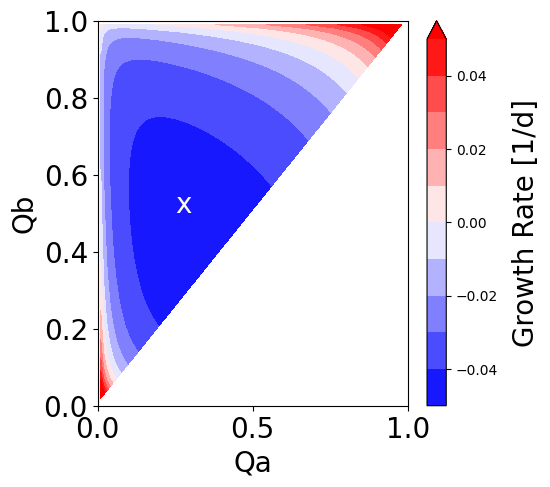

In [11]:
# And finally the actual plot
fig, ax = plt.subplots(1, 1, figsize = (5,5))
cp = ax.contourf(qas, qbs, hm,
                 cmap="bwr",
                 levels=np.arange(-0.05, 0.051, .01),
                 extend="max")
cbar = plt.colorbar(cp)

# Annotate the values (Qa, Qb) we decide to investigate in the following
Qa = 0.25
Qb = 0.5
ax.annotate(r"x", (Qa, Qb), fontsize=20, color="white")

# General aesthetics
cbar.ax.set_ylabel('Growth Rate [1/d]',
                   labelpad=10, fontsize=20)
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.tick_params("both", labelsize=20)
ax.set_xlabel("Qa", size=20)
ax.set_ylabel("Qb", size=20)

# Figure 3c of our manuscript

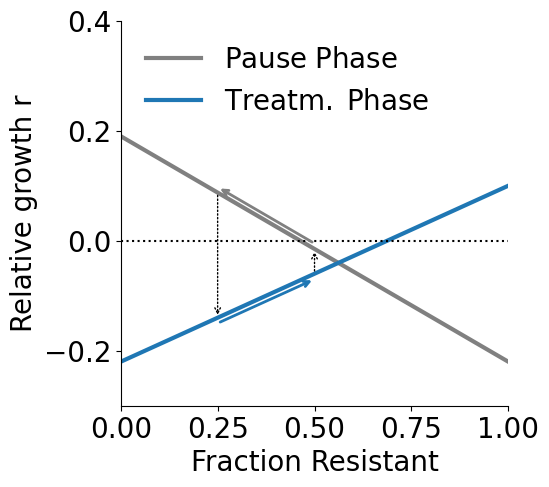

In [12]:
# Parameter estimates from previous fit
beta_S_star = -0.22
beta_R_star = 0.10
alpha = .02
beta_S = 0.19
beta_R = -0.22
delta = 0.10

# The interval borders for Q(t) which we have previously selected
Qa = 0.25
Qb = 0.50

# Helper functions for evaulating the two linear functions r(Q) at a given point q
def r_T(q):
    return beta_S_star + (beta_R_star-beta_S_star)*q

def r_P(q):
    return beta_S + (beta_R-beta_S)*q

# Plot the two lines
fig, ax = plt.subplots(1, 1, figsize = (5,5))
xs = np.arange(0,2,0.01)
ax.plot(xs, r_P(xs), c="grey", lw=3, linestyle="-", label="$\mathrm{Pause \; Phase}$")
ax.plot(xs, r_T(xs), c="C0", lw=3, linestyle="-", label="$\mathrm{Treatm. \; Phase}$")

# Draw the illustrative arrows which sketch out the treatment protocol
ax.annotate("", (Qa,r_T(Qa)), (Qa,r_P(Qa)), arrowprops={"arrowstyle": "->", "ls":":"})
ax.annotate("", (Qb,r_P(Qb)), (Qb,r_T(Qb)), arrowprops={"arrowstyle": "->", "ls":":"})
ax.annotate("", (Qa,r_P(Qa)+0.01), (Qb,r_P(Qb)+0.01) ,arrowprops={"arrowstyle": "->", "color":"grey", "lw":2})
ax.annotate("", (Qb,r_T(Qb)-0.01), (Qa,r_T(Qa)-0.01), arrowprops={"arrowstyle": "->", "color": "C0", "lw":2})


# General aesthetics
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0,1))
ax.set_ylim((-0.3,0.4))
ax.tick_params("both", labelsize=20)
ax.set_xlabel("Fraction Resistant", size=20)
ax.set_ylabel("Relative growth r", size=20)
ax.legend(loc=2, frameon=False, fontsize=20)
ax.hlines([0], 0, 1, color="black", ls=":")

# Figure 3d of our manuscript

In [13]:
# The parameter estimates from the previous fit
beta_S_star = -0.22
beta_R_star = 0.10
alpha = .02
beta_S = 0.19
beta_R = -0.22
delta = 0.10

# Interval borders on Q(t) which describe the protocol we have selected
Qa = .25
Qb = 0.50

# Helper functions encoding the events of the tumour reaching Qb and Qa, respectively
# These are just needed for the numerical simulation and tell the solver to stop
def reached_Qb(t,Y):
    _, Q = Y
    return Qb-Q
reached_Qb.terminal = True

def reached_Qa(t,Y):
    _, Q = Y
    return Qa-Q
reached_Qa.terminal = True
    
# We want to compare our approach to the -50% stopping criterion by Kim et al.,
# hence we encode their protocol by another pair of event functions.
# Since we start with a tumour of 10^6 cells, we can hard-code the switching points:
def reached_50(t, Y):
    N, _ = Y
    return 5e5 - N
reached_50.terminal = True

def reached_100(t, Y):
    N, _ = Y
    return 1e6 - N
reached_100.terminal = True

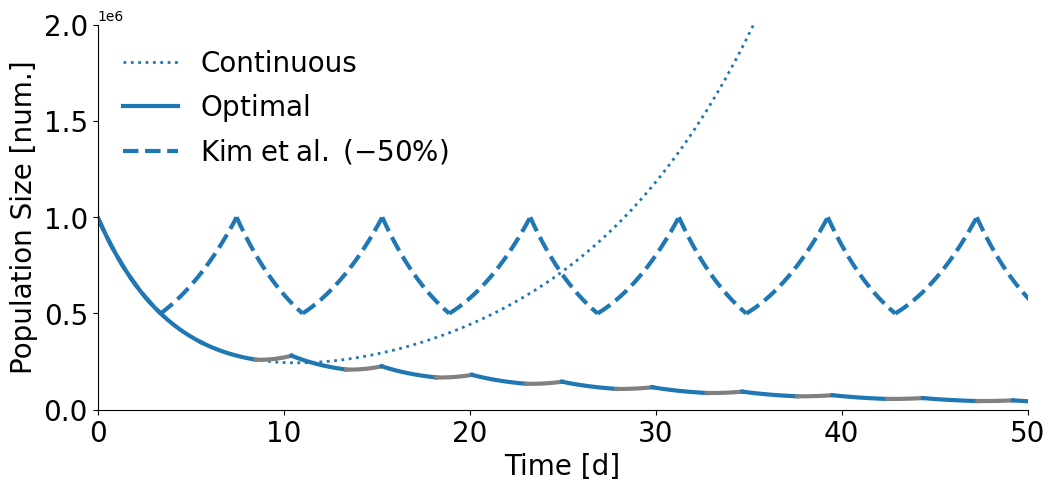

In [15]:
# Make plot
fig, ax = plt.subplots(1, 1, figsize = (12,5))

# First, we simulate the case of continuous treatment
cont = solve_ivp(dYdt_T, t_span=(0,50), y0=[1e6,0], max_step = 0.01)
ax.plot(cont.t, cont.y[0], c="C0", ls=":", lw=2, label="Continuous")

# Next, we simulate 10 cycles of the -50% stopping criterion by Kim et al.:

# Initial conditions
t_cur = 0
N_cur = 1e6
Q_cur = 0

# And the 10 cycles
for _ in range(10):
    # Treat until we have reached a 50% reduction from initial volume,
    # i.e. until we reach 0.5*10^6 = 5*10^5 cells
    treat = solve_ivp(dYdt_T, t_span=(0,50), y0=[N_cur, Q_cur], max_step = 0.01, events=reached_50)
    ax.plot(t_cur+treat.t, treat.y[0], c="C0",lw=3, ls="--")
    t_cur += treat.t[-1]
    N_cur = treat.y[0][-1]
    Q_cur = treat.y[1][-1]

    # Then pause, until we reach the initial tumour volume of 10^6 cells again
    pause = solve_ivp(dYdt_P, t_span=(0,50), y0=[N_cur, Q_cur], max_step = 0.01, events=reached_100)
    ax.plot(t_cur+pause.t, pause.y[0], c="C0",lw=3, ls="--")
    t_cur += pause.t[-1]
    N_cur = pause.y[0][-1]
    Q_cur = pause.y[1][-1]
    
# And finally, we simulate our optimised protocol:

# We begin with the initial transient during which Q(t) increases from 0 to Qa
transient = solve_ivp(dYdt_T, t_span=(0,50), y0=[1e6,0], max_step = 0.01, events=reached_Qa)
ax.plot(transient.t, transient.y[0], c="C0", ls="-", lw=3, label="$\mathrm{Optimal}$")
# We need to update this after every step for plotting
t_cur = transient.t[-1] 

# Afterwards, treatment is continued until Q(t) reaches Qb
# (This could have been included in the previous step, but we wanted to make clear
# explicitly the initial transient to approach Qa from below.
treat = solve_ivp(dYdt_T, t_span=(0,50), y0=[transient.y[0][-1],Qa], max_step = 0.01, events=reached_Qb)
ax.plot(t_cur+treat.t, treat.y[0], c="C0",lw=3)
t_cur += treat.t[-1]

# And now we only have to cycle between treatment pauses and treatment,
# which we here do 10 times.
for _ in range(10):
    # Pause until Q(t) has decreased to Qa again
    pause = solve_ivp(dYdt_P, t_span=(0,50), y0=[treat.y[0][-1],Qb], max_step = 0.01, events=reached_Qa)
    ax.plot(t_cur+pause.t, pause.y[0], c="grey",lw=3)
    t_cur += pause.t[-1]

    # Treat until Q(t) has reached Qb again
    treat = solve_ivp(dYdt_T, t_span=(0,50), y0=[pause.y[0][-1],Qa], max_step = 0.01, events=reached_Qb)
    ax.plot(t_cur+treat.t, treat.y[0], c="C0",lw=3)
    t_cur += treat.t[-1]

    
# General aesthetics
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim((0,50))
ax.set_ylim((0,2e6))
ax.tick_params("both", labelsize=20)
ax.set_xlabel("Time [d]", size=20)
ax.set_ylabel("Population Size [num.]", size=20)
ax.legend(loc=2, frameon=False, fontsize=15)

# Legend
# Just a line hidden outside the plotting area, so that the legend is generated properly
ax.plot((-100,-20), (-100,-20),
         c="C0", lw=3, ls="--",
         label="$\mathrm{Kim \; et \; al. \; (-50\%)}$")
ax.legend(fontsize=20, frameon=False)